In [28]:
import os
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler
from tensorflow.keras.models import Sequential
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix


warnings.filterwarnings('ignore')

# Entendimento dos dados

In [2]:
data = pd.read_csv(os.getcwd()+'\\data\\raw\\card_transdata.csv')

In [3]:
data

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...
999995,2.207101,0.112651,1.626798,1.0,1.0,0.0,0.0,0.0
999996,19.872726,2.683904,2.778303,1.0,1.0,0.0,0.0,0.0
999997,2.914857,1.472687,0.218075,1.0,1.0,0.0,1.0,0.0
999998,4.258729,0.242023,0.475822,1.0,0.0,0.0,1.0,0.0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   distance_from_home              1000000 non-null  float64
 1   distance_from_last_transaction  1000000 non-null  float64
 2   ratio_to_median_purchase_price  1000000 non-null  float64
 3   repeat_retailer                 1000000 non-null  float64
 4   used_chip                       1000000 non-null  float64
 5   used_pin_number                 1000000 non-null  float64
 6   online_order                    1000000 non-null  float64
 7   fraud                           1000000 non-null  float64
dtypes: float64(8)
memory usage: 61.0 MB


In [5]:
data.isnull().sum()

distance_from_home                0
distance_from_last_transaction    0
ratio_to_median_purchase_price    0
repeat_retailer                   0
used_chip                         0
used_pin_number                   0
online_order                      0
fraud                             0
dtype: int64

Até aqui podemos ver que não há valores nulos, e que os dados estão na tipagem correta para a análise, o que vai facilitar nosso trabalho.

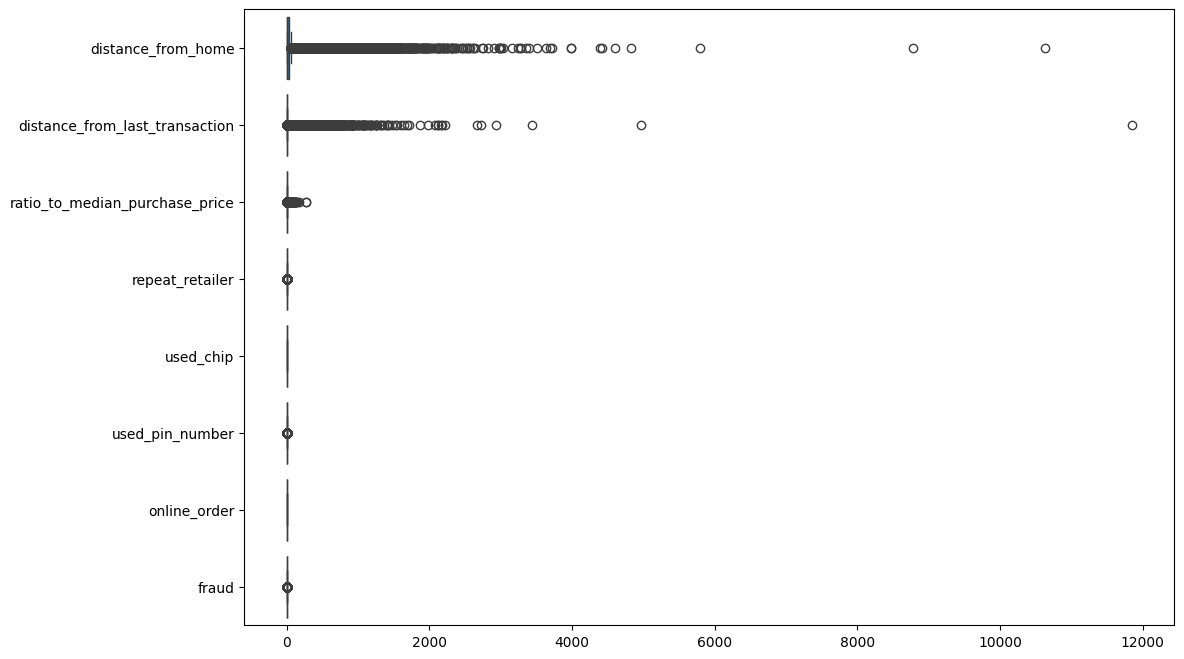

In [6]:
plt.figure(figsize=(12,8))
sns.boxplot(data=data, orient = 'h')
plt.show()

A primeira vista conseguimos perceber que há uma quantidade expressiva de outliers referente à distância da casa da pessoa e suas compras, e também as distâncias das ultimas compras. Até o momento grande parte desses outliers podem ser caracterizados como compras normais, uma vez que a pessoa não compra somente na internet e pode usar o cartão de crédito na região onde mora, ou até mesmo em locais mais distantes no caso de viagens. Porém ainda não desconsidero a hipótese de que possa ser algumas compras fraudulentas. 

Também podemos ver uma anormalidade no valor médio das compras, mas para que consigamos tirar um insight deveremos análisar mais precisamente com o uso de um gráfico de correlações.

Muito importante destacar que nosso conjunto de dados apresenta muitas linhas, e isso poderá atrasar muito nossa análise. Dito isso, posteriormente iremos análisar apenas uma parte deles com amostras.

In [7]:
# criando um novo dataframe com apenas 30% dos dados originais
data20 = data.sample(frac=0.2, random_state=42)

In [8]:
data20

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
987231,0.929509,1.296477,0.361110,0.0,0.0,0.0,1.0,0.0
79954,0.611179,0.208295,3.118884,0.0,0.0,0.0,1.0,0.0
567130,3.956062,0.529194,1.579942,1.0,0.0,0.0,0.0,0.0
500891,21.798902,0.019399,11.416909,1.0,0.0,0.0,0.0,0.0
55399,3.310635,1.707802,2.028915,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
90245,56.686649,0.820179,6.051695,1.0,0.0,1.0,1.0,0.0
639296,5.544863,0.072644,1.350344,1.0,0.0,0.0,1.0,0.0
311939,4.449740,2.045690,9.814511,1.0,1.0,0.0,1.0,1.0
324459,34.624330,0.580115,0.424248,1.0,0.0,0.0,0.0,0.0


In [9]:
data20.describe()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.00000,200000.000000,200000.000000,200000.000000
mean,26.665327,5.075146,1.820090,0.881615,0.35057,0.100315,0.650490,0.087215
std,66.093964,23.592924,2.819101,0.323064,0.47715,0.300420,0.476816,0.282151
min,0.021322,0.000419,0.005741,0.000000,0.00000,0.000000,0.000000,0.000000
25%,3.866707,0.296265,0.476025,1.000000,0.00000,0.000000,0.000000,0.000000
50%,9.981617,1.000009,0.997039,1.000000,0.00000,0.000000,1.000000,0.000000
75%,25.751134,3.346657,2.096641,1.000000,1.00000,0.000000,1.000000,0.000000
max,10632.723672,2663.513077,267.802942,1.000000,1.00000,1.000000,1.000000,1.000000


### Erro-padrão

In [10]:
standard_error = data20.sem()
print(f'Erro padrão: {standard_error}')

Erro padrão: distance_from_home                0.147791
distance_from_last_transaction    0.052755
ratio_to_median_purchase_price    0.006304
repeat_retailer                   0.000722
used_chip                         0.001067
used_pin_number                   0.000672
online_order                      0.001066
fraud                             0.000631
dtype: float64


Aqui vemos que o erro-padrão é sempre muito próximo de 0, o que indica que nossa amostra reflete bem a população.

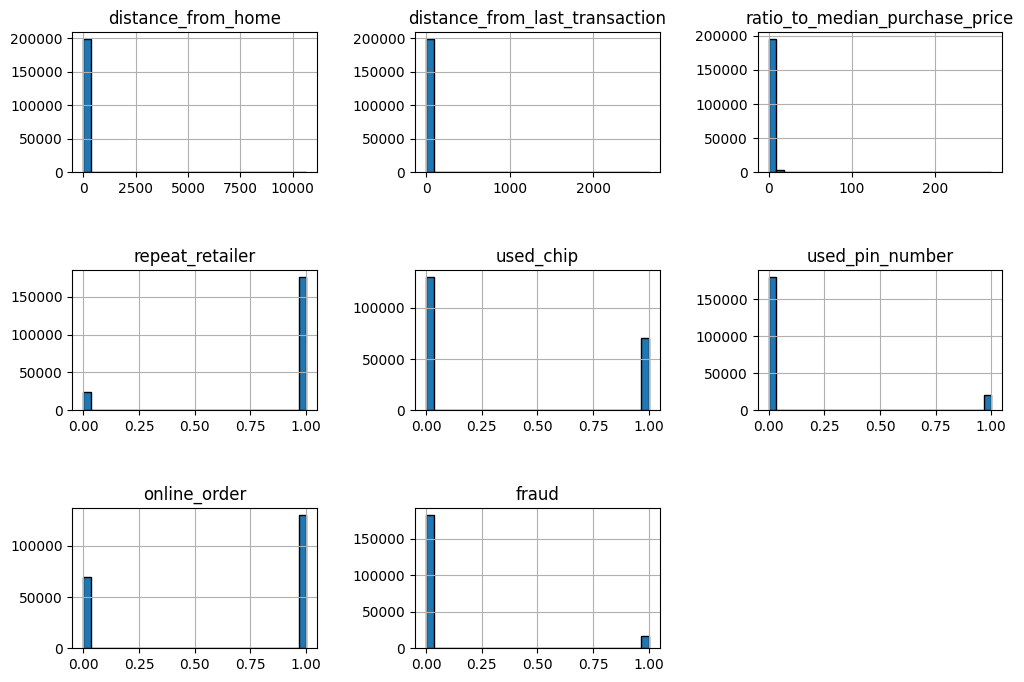

In [11]:
data20.hist(figsize=(12,8), bins=30, edgecolor='black')
plt.subplots_adjust(hspace=0.7, wspace=0.4)
plt.show()

### Alguns insights até o momento:
 - repead_retailer | A maioria das compras ocorreram nos mesmos varejistas.
  
 - used_chip | Nos mostra que o uso do cartão de crédito físico foi menos da metade das formas de pagamento, o que sugere que algumas pessoas ainda optam por não usa-lo, e talvez prefiram o modelo de cartão digital.
  
 - used_pin_number | Aqui me chamou a atenção, o número de registros que usaram a chave PIN foi baixíssima se comparada ao total. Isso nos leva pensar que:
   - As pessoas não se preocupam muito com a segurança dos seus cartões ou não tem tanta conciência dos riscos que correm deixando seus dados tão vulneráveis.
   - Por praticidade e comodidade configuram seus aparelhos para não pedir o PIN ao fazer compras.
   - Deixam seus dados salvos no aparelho para futuras compras.
  
 -  online_order | A maioria das compras são feitas online. Isso pode ser um benefício pela praticidade, e um malefício pois entrega uma facilidade em aplicação de cyber golpes.

 - fraud | Percebemos uma pequena quantidade de fraudes. 


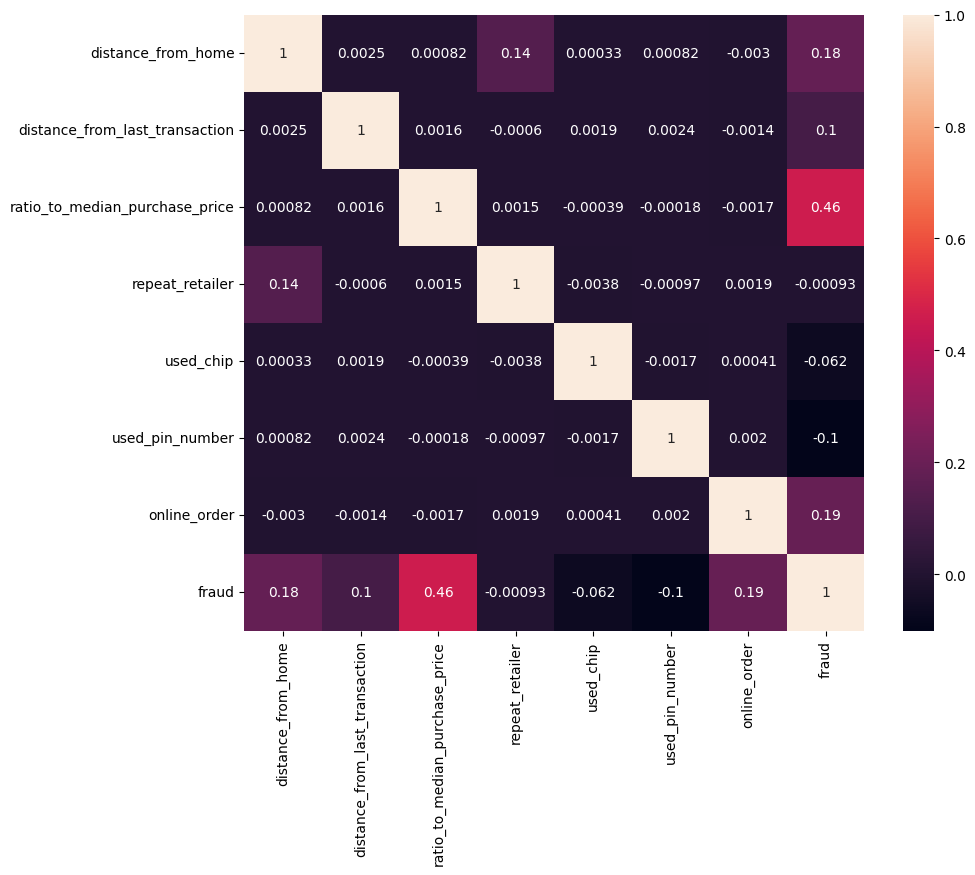

In [12]:
plt.figure(figsize=(10,8))
sns.heatmap(data20.corr(), annot=True)
plt.show()

#### Notamos:
 - preço médio por compra X fraude: Apesar de uma correlação não MUITO forte de apenas 0.46, conseguimos ver que sim, um dos indicadores para fraudes é a quebra de padrão nas compras é algo a ser considerado como fraude.

 - compra online X fraude: No gráfico a correlação também não é tão alta, mes devemos levar em, consideração que uma parte significante das fraudes nos cartões vem de forma digital, e alguns fatores que consideramos acima nos leva a crer mais nisso.
  
 - distância de casa X fraude: Algo que também faz sentido, na era digitl que vivemos é muito simples para um golpista experiente cometer essas atividades em um local diferente da vítima.
  
 - usando o PIN X fraude: Percebe-se também que nas fraudes não é utilizado o PIN.

 - usando chip de cartão físico X fraude: Algo também a se notar pois os registros de fraudes não apresentam o uso de chip registrado. O que nos leva a crer que ou os cartões podem ter sido clonados ou os crimes podem ter ocorrido por meio de máquinas como computador e celular por exemplo.

 - compras no mesmo logista X fraude: há uma correlação negativa, um registro de fraude muito dificilmente é ocorrido no mesmo varegista.

In [13]:
#sns.pairplot(data20, hue='fraud', palette='Set1')
#plt.show()

### Qual a porcentagem de fraudes em compras online?

In [14]:
online_purchase = data20['online_order'] == 1

online_purchase.sum()

130098

In [15]:
fraud = data20['fraud'] == 1
fraud.sum()

17443

In [16]:
online_fraud = data20.loc[(online_purchase)&(fraud)]
online_fraud

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
731479,131.560300,1.879859,0.576109,1.0,0.0,0.0,1.0,1.0
272966,130.347043,0.423152,0.156390,1.0,0.0,0.0,1.0,1.0
348365,2.798701,2.308785,6.689793,1.0,0.0,0.0,1.0,1.0
804703,16.242643,1.524342,9.083912,1.0,0.0,0.0,1.0,1.0
980753,1.579326,3.085839,6.425476,0.0,1.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...
760174,2.884511,0.207147,9.286391,1.0,0.0,0.0,1.0,1.0
120459,11.877324,4.417659,7.576243,1.0,1.0,0.0,1.0,1.0
242435,120.060796,0.162540,13.472413,1.0,0.0,0.0,1.0,1.0
413723,137.612475,60.831686,1.157098,1.0,1.0,0.0,1.0,1.0


In [17]:
porc_online_fraud = len(online_fraud)/fraud.sum() *100
print(porc_online_fraud)

94.49062661239466


 - Temos um total de 130098 registros de compras online nesta amostra.
 - Um total de 17443 de fraudes na amostra.
 - De 17443 fraudes, 16482 são online.
  
94,5% das fraudes são transações online.

### Qual a porcentagem de fraudes em relação ao uso do chip do cartão de crédito?

Aproximadamente 4,5% das fraudes ocorrem por uso físico dos cartões de crédito.

### Analisando a diferença de gastos dos registros com fraude e sem fraude

In [18]:
fraud_describe = data20.ratio_to_median_purchase_price[data20.fraud == 1]
fraud_describe.describe()

count    17443.000000
mean         5.995095
std          5.386539
min          0.025146
25%          3.806527
50%          5.074410
75%          7.334551
max        101.985360
Name: ratio_to_median_purchase_price, dtype: float64

In [19]:
not_fraud_describe = data20.ratio_to_median_purchase_price[data20.fraud == 0]
not_fraud_describe.describe()

count    182557.000000
mean          1.421176
std           2.027291
min           0.005741
25%           0.449620
50%           0.911872
75%           1.782679
max         267.802942
Name: ratio_to_median_purchase_price, dtype: float64

diante a análise da proporção de compra mediana, conseguimos identificar que em média um fraudador costuma gastar cerca de 5x mais, e que 75% dos gastos chegam a ser até 7x mais que o comum.

# Modelagem de dados

In [29]:
x = data20.drop('fraud', axis=1)
y = data20.fraud

In [21]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=42)

In [30]:
scaler = RobustScaler()

## Regressão Logística

              precision    recall  f1-score   support

         0.0       0.96      0.99      0.98     36595
         1.0       0.89      0.60      0.71      3405

    accuracy                           0.96     40000
   macro avg       0.93      0.79      0.85     40000
weighted avg       0.96      0.96      0.96     40000

------------------------------------------------------------
A acurácia do modelo de Regressão Logística é: 0.959325
------------------------------------------------------------


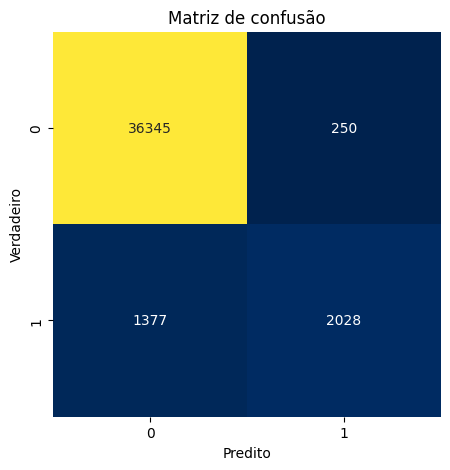

In [42]:
# atribuindo modelo
model_log_reg = LogisticRegression()

# criando pipeline
pipeline_log_reg = make_pipeline(RobustScaler(), model_log_reg)

# ajustando modelo aos dados de treino
pipeline_log_reg.fit(x_train,y_train)

# fazendo previsões nos dados de teste
y_pred_reg_log = pipeline_log_reg.predict(x_test)

# calculando métricasa de validação de modelo
    # Acurácia
accuracy_reg_log = accuracy_score(y_test,y_pred_reg_log)
    # Matriz de confusão
cm_log_reg = confusion_matrix(y_test, y_pred_reg_log)

# exibindo F1-score e Recall
print(classification_report(y_test,y_pred_reg_log))
print('-'*60)

# exibindo Acurácia
print('A acurácia do modelo de Regressão Logística é:', accuracy_reg_log)
print('-'*60)

# Exibindo Matrix de confusão
plt.figure(figsize=(5,5))
sns.heatmap(cm_log_reg, annot=True, fmt='d', cmap=('cividis'), cbar=False)
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.title('Matriz de confusão')
plt.show()


## Árvore de Decisão

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     36595
         1.0       1.00      1.00      1.00      3405

    accuracy                           1.00     40000
   macro avg       1.00      1.00      1.00     40000
weighted avg       1.00      1.00      1.00     40000

------------------------------------------------------------
A acurácia do modelo de Árvore de Decisão é: 0.999825
------------------------------------------------------------


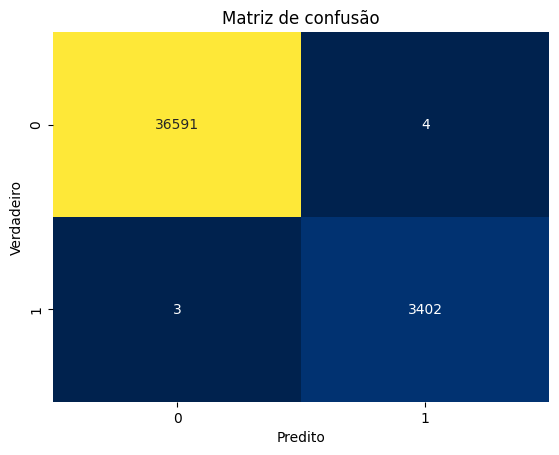

In [44]:
# atribuindo modelo
model_dt = DecisionTreeClassifier()

# criando pipeline
pipeline_dt = make_pipeline(RobustScaler(), model_dt)

# ajustando modelo aos dados de treino
pipeline_dt.fit(x_train, y_train)

# fazendo previsões nos dados de teste
y_pred_dt = pipeline_dt.predict(x_test)

# calculando métricas de validaçõ de modelo
    # Acurácia
accuracy_dt = accuracy_score(y_test, y_pred_dt)
    # Matriz de confusão
cm_dt = confusion_matrix(y_test, y_pred_dt)


# exibindo F1-Score e Recall
print(classification_report(y_test,y_pred_dt))

# exibindo Acurácia
print('-'*60)
print('A acurácia do modelo de Árvore de Decisão é:', accuracy_dt)
print('-'*60)

# exibindo Matriz de Confusão
sns.heatmap(cm_dt, annot=True,fmt='d', cmap='cividis', cbar=False)
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.title('Matriz de confusão')
plt.show()

## SVM (Support Vector Machines)

              precision    recall  f1-score   support

         0.0       0.94      0.99      0.97     36595
         1.0       0.79      0.35      0.48      3405

    accuracy                           0.94     40000
   macro avg       0.87      0.67      0.73     40000
weighted avg       0.93      0.94      0.93     40000

------------------------------------------------------------
A acurácia do modelo de Árvore de Decisão é: 0.936675
------------------------------------------------------------


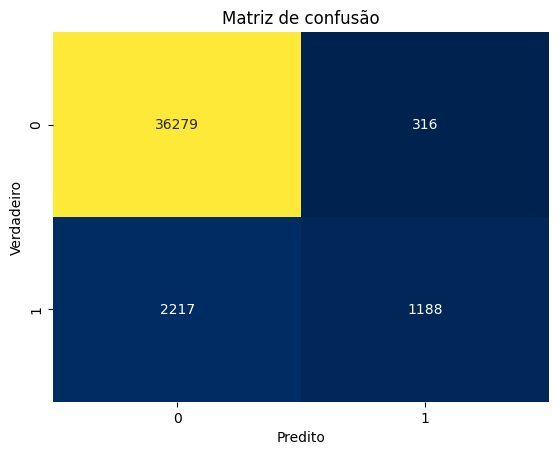

In [46]:
# criando modelo
model_svm = SVC(kernel='rbf')

# ajustando modelo aos dados de treino
model_svm.fit(x_train, y_train)

# fazendo previsões nos dados de teste
y_pred_svm = model_svm.predict(x_test)

# calculando métricas de validação de modelo
    # Acurácia
accuracy_svm = accuracy_score(y_test, y_pred_svm)
    # Matriz de confusão
cm_svm = confusion_matrix(y_test, y_pred_svm)

# exibindo F1-Score e Recall
print(classification_report(y_test,y_pred_svm))

# exibindo Acurácia
print('-'*60)
print('A acurácia do modelo de Árvore de Decisão é:', accuracy_svm)
print('-'*60)

sns.heatmap(cm_svm, annot=True, fmt='d', cmap='cividis', cbar=False)
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.title('Matriz de confusão')
plt.show()

## Redes Neurais Artificiais (ANN)